# Extrinsic camera calibration

In [14]:
# Imports
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

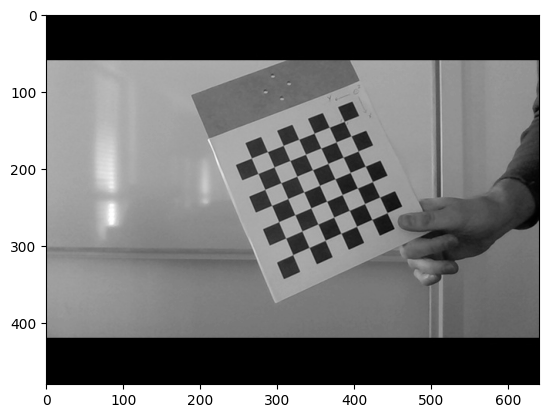

In [9]:
# Load images
camera_calibration_images_file = '../data/camera_calibration_*.jpg'
images_path_names = glob.glob(camera_calibration_images_file)

# Get first image
image = cv2.imread(images_path_names[0])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

### Detect corners

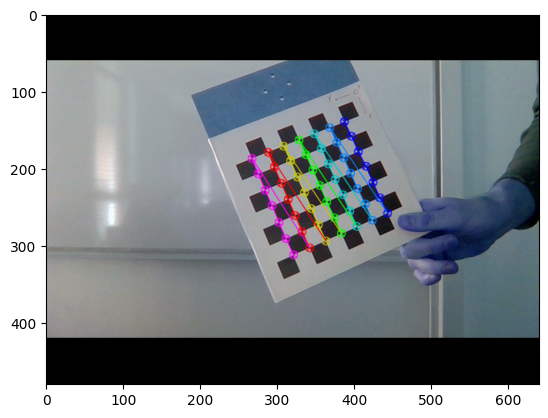

In [12]:
# Detect corners in chessboard
pattern = (7, 7)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
found, corners = cv2.findChessboardCorners(gray, pattern, None)
corners = cv2.cornerSubPix(gray, corners, pattern, (-1, -1), criteria)

# Show detected corners
image = cv2.drawChessboardCorners(image, pattern, corners, True)
plt.imshow(image)
plt.show()

### Calibrate camera

In [15]:
# Get user defined world coordinates
objp = objp = np.zeros((pattern[0] * pattern[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern[0], 0:pattern[1]].T.reshape(-1, 2) * 0.02  # 20x20 mm

In [16]:
# Initialize empty arrays for world and pixel cooridnates
imgpoints = []
objpoints = []

In [17]:
# Iterate over all images
for image_path in images_path_names:

    # Read image from file
    image = cv2.imread(image_path)

    # Convert RGB image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners in the image
    found, corners = cv2.findChessboardCorners(gray, pattern, None)
    corners = cv2.cornerSubPix(gray, corners, pattern, (-1, -1), criteria)

    # Add object points to objpoints list
    objpoints.append(objp)

    # Add pixel coordinates to imgpoints list
    imgpoints.append(corners)


In [18]:
# Check dimensions of arrays
print("Dimensions of world coordinate array: " + str(np.shape(objpoints)))
print("Dimensions of pixel coordinate array: " + str(np.shape(imgpoints)))

Dimensions of world coordinate array: (10, 49, 3)
Dimensions of pixel coordinate array: (10, 49, 1, 2)


In [21]:
# Calibrate camera and obtain intrinsic camera matrix using the objpoints list and the imgpoints list
ret, mtx, dist, rvecs, tvecs  =  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)

[[471.10988889   0.         322.83819053]
 [  0.         471.60211114 238.95389278]
 [  0.           0.           1.        ]]


In [22]:
# Calculate reprojection error
tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    tot_error += error
print("\nTotal reprojection error: %f" % (tot_error / float(len(objpoints))))


Total reprojection error: 0.014542


### Evaluate calibration

In [23]:
# Define axis and box coordinates in camera coordinate system
axis = np.float32([[0.06, 0, 0], [0, 0.06, 0], [0, 0, 0.06], [0, 0, 0]])
square1 = np.float32([[0.08, 0.06, 0.5], [0.12, 0.06, 0.5], [0.12, 0.10, 0.5], [0.08, 0.10, 0.5]]).reshape(-1, 3)
square2 = np.float32([[0.08, 0.06, 0.6], [0.12, 0.06, 0.6], [0.12, 0.10, 0.6], [0.08, 0.10, 0.6]]).reshape(-1, 3)
square3 = np.float32([[0.08, 0.06, 1.7], [0.12, 0.06, 1.7], [0.12, 0.10, 1.7], [0.08, 0.10, 1.7]]).reshape(-1, 3)

In [37]:
# Draw axis on image
def draw_axis(img, imgpts):
    imgpts = imgpts.astype(int)
    img = cv2.line(img, tuple(imgpts[3].ravel()), tuple(imgpts[0].ravel()), (0, 0, 255), 5)
    img = cv2.line(img, tuple(imgpts[3].ravel()), tuple(imgpts[1].ravel()), (0, 255, 0), 5)
    img = cv2.line(img, tuple(imgpts[3].ravel()), tuple(imgpts[2].ravel()), (255, 0, 0), 5)
    text_pos = (imgpts[0].ravel() + np.array([3.5, -7])).astype(int)
    cv2.putText(img, 'X', tuple(text_pos), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))
    text_pos = (imgpts[1].ravel() + np.array([3.5, -7])).astype(int)
    cv2.putText(img, 'Y', tuple(text_pos), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))
    text_pos = (imgpts[2].ravel() + np.array([3.5, -7])).astype(int)
    cv2.putText(img, 'Z', tuple(text_pos), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))
    text_pos = (imgpts[3].ravel() + np.array([3.5, -7])).astype(int)
    return img

# Draw square on image
def draw_square(img, imgpts):
    imgpts = imgpts.astype(int)
    img = cv2.line(img, tuple(imgpts[0].ravel()), tuple(imgpts[1].ravel()), (0, 0, 255), 3)
    img = cv2.line(img, tuple(imgpts[1].ravel()), tuple(imgpts[2].ravel()), (0, 0, 255), 3)
    img = cv2.line(img, tuple(imgpts[2].ravel()), tuple(imgpts[3].ravel()), (0, 0, 255), 3)
    img = cv2.line(img, tuple(imgpts[3].ravel()), tuple(imgpts[0].ravel()), (0, 0, 255), 3)
    return img

In [38]:
# Project 3D axis points to pixel coordinates
imgpts_axis, _ = cv2.projectPoints(axis, np.identity(3), np.zeros((3, 1)), mtx, dist)

# Project 3D box points to pixel coordinates
imgpts_square1, _ = cv2.projectPoints(square1, np.identity(3), np.zeros((3, 1)), mtx, dist)

# Project 3D box points to pixel coordinates
imgpts_square2, _ = cv2.projectPoints(square2, np.identity(3), np.zeros((3, 1)), mtx, dist)

# Project 3D box points to pixel coordinates
imgpts_square3, _ = cv2.projectPoints(square3, np.identity(3), np.zeros((3, 1)), mtx, dist)

# Draw axis on image
image = draw_axis(image, imgpts_axis)

# Draw square 1 on image
image = draw_square(image, imgpts_square1)

# Draw square 2 on image
image = draw_square(image, imgpts_square2)

# Draw square 3 on image
image = draw_square(image, imgpts_square3)

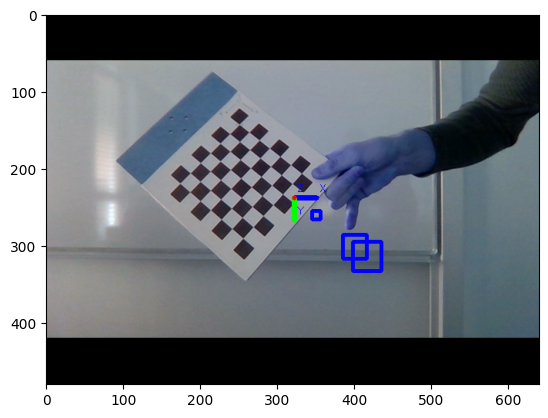

In [41]:
# Show result
plt.imshow(image, cmap='gray')
plt.show()